In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from common import *
import shutil
from competitions.dsb2017 import dsbconfig as comp;
import dicom
import scipy.ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from nbpapaya import Brain, clear_brain, Brain, Surface, Overlay
import SimpleITK as sitk
import csv
from tqdm import tqdm
import xml
import ntpath
from bs4 import BeautifulSoup
import cv2
import multiprocessing

In [ ]:
PROJECT_PATH = os.path.join('/bigguy/data/luna')
DATA_PATH = os.path.join('/bigguy/data/luna/data')
META_PATH = os.path.join(PROJECT_PATH, 'csv')
LUNA_DATA_PATH = os.path.join('/bigguy/data/luna/data')
LUNA_EXTRACTED_IMAGE_PATH = os.path.join(PROJECT_PATH, 'luna_extracted_imgs')
LUNA_CUBES_POS_PATH = os.path.join(PROJECT_PATH, 'luna_cubes_pos_imgs')
LUNA_CUBES_NEG_PATH = os.path.join(PROJECT_PATH, 'luna_cubes_neg_imgs')
EXTRACTED_LABEL_PATH = os.path.join(PROJECT_PATH, 'extracted_labels')
ANNOTATIONS_PATH = os.path.join(META_PATH, 'annotations.csv')
LIDC_ANNO_PATH = os.path.join(META_PATH, 'lidc_annotations')
LUNA_NEG_CANDIDATES_PATH = os.path.join(META_PATH, 'luna_neg_candidates.csv')
MEAN_PIXEL_VALUE_NODULE = 41
SEGMENTER_IMG_SIZE = 320
TARGET_VOXEL_MM = 1.00
VOXEL_SPACING = [TARGET_VOXEL_MM, TARGET_VOXEL_MM, TARGET_VOXEL_MM]
subset_path = os.path.join(DATA_PATH, 'subset0')
fpaths = glob(subset_path+"/*.mhd")

In [ ]:
# LIDC
# https://wiki.cancerimagingarchive.net/download/attachments/3539039/LIDC_XML_Documentation_1_Jan_2009.doc?version=1&modificationDate=1319224566057&api=v2
"""
The LIDC used a two phase reading process. In the first phase, multiple readers (N=4 as of Jan 2006), read and annotated each case independently in a blinded fashion.  That is, they all read the same cases, but they the readings were done asynchronously and independently.  After the results of that first, blinded reading were complete, they were compiled and sent back out to the same readers so that they could see both their own markings as well as the markings from the other three readers.  Each reader then, again independently, read each case, this time with the benefit of information as to what other readers saw/marked, and then made a final decisions about the markings for that case.

3 step annotation process:
1) Blind read by 4 radiologists
2) Each radiologist showed the annotations of the others
3) Unblind read by 4 radiologists

IMAGES ONLY INCLUDE THE 2nd Unblinded Read

Interesting!!
Malignancy - Radiologist subjective assessment of likelihood of malignancy of this nodule, ASSUMING  60-year-old male smoker 

3 Types of Annotations:
1) Nodules >= 3mm diameter 
    - Complete outline (segmentation)
    - Include characteristics (e.g. malignancy)
2) Nodules < 3mm diameter 
    - Center of mass labeled (x,y,z)
    - Do not include characteristics
3) Non-Nodules > 3mm  diameter
    - Center of mass labeled (x,y,z)
    - Do not include characteristics

* Non-Nodules < 3mm were NOT marked! (might confuse the model)

Terms
-----
* Scan files = 158.xml, 162.xml..
* SeriesInstanceUid = Patient
* StudyInstanceUID = Scan 
* nodule id – a unique id for the nodule marked by this reader
* Nodule Contour ROI – this is the description of the complete three dimensional contour of the nodule (remembering that the radiologist was instructed to mark the first voxel outside the nodule)
* Inclusion – “True” means that the roi that follows is considered part of the nodule; “False” means that the roi that follows should be subtracted from the nodule.
* Locus – is unique to non-nodules (and is used in place of “edge map”) and indicates that the indicator point of the non-nodule is to follow:
<locus>				beginning of non-nodule description
<xCoord>215</xCoord>		x coordinate location of non-nodule
<yCoord>312</yCoord>		y coordinate location of non-nodule
</locus>				end of non-nodule description


<SeriesInstanceUid>1.3.6.1.4.1.14519.5.2.1.6279.6001.303494235102183795724852353824</SeriesInstanceUid>
<StudyInstanceUID>1.3.6.1.4.1.14519.5.2.1.6279.6001.339170810277323131167631068432</StudyInstanceUID>


* Nodules >= 3mm diameter 

 <unblindedReadNodule>
   <noduleID>6</noduleID>
   <characteristics>
    <subtlety>5</subtlety>
    <internalStructure>1</internalStructure>
    <calcification>4</calcification>
    <sphericity>3</sphericity>
    <margin>5</margin>
    <lobulation>2</lobulation>
    <spiculation>3</spiculation>
    <texture>5</texture>
    <malignancy>4</malignancy>
   </characteristics>
   
   ## ROIS are the same nodule on different slices
   <roi>
    <imageZposition>1616.5</imageZposition>
    <imageSOP_UID>1.3.6.1.4.1.14519.5.2.1.6279.6001.315628943944666928553332863367</imageSOP_UID>
    <inclusion>TRUE</inclusion>
    <edgeMap><xCoord>339</xCoord><yCoord>240</yCoord></edgeMap>
    <edgeMap><xCoord>338</xCoord><yCoord>241</yCoord></edgeMap>
    <edgeMap><xCoord>337</xCoord><yCoord>242</yCoord></edgeMap>
   </roi>
   <roi>
    <imageZposition>1616.5</imageZposition>
    <imageSOP_UID>1.3.6.1.4.1.14519.5.2.1.6279.6001.315628943944666928553332863367</imageSOP_UID>
    <inclusion>TRUE</inclusion>
    <edgeMap><xCoord>339</xCoord><yCoord>240</yCoord></edgeMap>
    <edgeMap><xCoord>338</xCoord><yCoord>241</yCoord></edgeMap>
    <edgeMap><xCoord>337</xCoord><yCoord>242</yCoord></edgeMap>
   </roi>
 </unblindedReadNodule>
 
 
 
* Nodules < 3mm diameter 

  <unblindedReadNodule>
   <noduleID>5</noduleID>
   <roi>
    <imageZposition>1631.5</imageZposition>
    <imageSOP_UID>1.3.6.1.4.1.14519.5.2.1.6279.6001.349696112719071080933041621585</imageSOP_UID>
    <inclusion>TRUE</inclusion>
    <edgeMap><xCoord>197</xCoord><yCoord>321</yCoord></edgeMap>
   </roi>
  </unblindedReadNodule>



* Non-Nodules > 3mm  diameter:

  <nonNodule>
   <nonNoduleID>2058</nonNoduleID>
   <imageZposition>1628.5</imageZposition>
   <imageSOP_UID>1.3.6.1.4.1.14519.5.2.1.6279.6001.216194661683946632889617404306</imageSOP_UID>
   <locus>
    <xCoord>199</xCoord><yCoord>320</yCoord>
   </locus>
  </nonNodule>
""";


In [116]:
def find_mhd_file(patient_id):
    for subject_no in range(10):
        src_dir = os.path.join(
            DATA_PATH, "subset" + str(subject_no)) + "/"
        for src_path in glob(src_dir + "*.mhd"):
            if patient_id in src_path:
                return src_path
    return None

def load_lidc_xml(xml_path, agreement_threshold=0, only_patient=None, save_nodules=False):
    """
    Writes 2 CSV files with nodule and non-nodule annotations
        - nodules >= 3mm
        - non-nodules
    Nodule annotations include: id, z, y, x, diameter, malignancy
    Coords and Diameter are stored as percent of image size
    Diameter is calculated as the max of x and y
        - We reduce irregularly shaped nodules into circles (boxes)
    Optionally include only nodules with radiologist agreement
    Ignores nodules < 3mm
    """
    pos_lines = []
    neg_lines = []
    extended_lines = []
    
    # Each LIDC xml file represents a read of a single 3D CT Scan (multiple slices)
    with open(xml_path, 'r') as xml_file:
        markup = xml_file.read()
    xml = BeautifulSoup(markup, features="xml")
    
    # Catch corrupt files
    if xml.LidcReadMessage is None:
        return None, None, None
    
    patient_id = xml.LidcReadMessage.ResponseHeader.SeriesInstanceUid.text

    # Option to filter for single patient
    if only_patient is not None:
        if only_patient != patient_id:
            return None, None, None

    # Load the CT Scan image by patient_id
    src_path = find_mhd_file(patient_id)
    if src_path is None:
        return None, None, None
    
    # Load the CT Scan with SimpleITK
    # This a 3D volume containing multiple 2D slices
    itk_img = sitk.ReadImage(src_path)
    
    # Convert to Numpy (z, 512, 512)
    img_array = sitk.GetArrayFromImage(itk_img)
    
    # z,y,x (height before width)
    num_z, height, width = img_array.shape        #heightXwidth constitute the transverse plane
    
    # Needed to calculate offet and normalize
    # Follow-up on this..
    origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
    spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
    
    # 1.00 is a hyperparameter 
#     # Rescale so that every voxel represents an volume of 1x1x1 mm
#     # Needed to ensure consistency across scans
#     rescale = spacing / 1.00 #1x1x1

    # Up to 4 per scan, one per radiologist
    reading_sessions = xml.LidcReadMessage.find_all("readingSession")
    
    # A reading session is all slices in CT Scan read by one radiologist
    for reading_session in reading_sessions:
        
        # Get the list of nodules (since up to 4 reads, many will identify the same nodule)
        nodules = reading_session.find_all("unblindedReadNodule")

        # Includes both >= 3 (characteristics and outline) and <3 (just the centroid)
        for nodule in nodules:
            nodule_id = nodule.noduleID.text # e.g. 1823
            
            # Same nodule appears in multiple slices (3D)
            rois = nodule.find_all("roi")
            
            # To create the annotations we're going to find the edges
            # of the outline, calculate the center
            # then use the diameter to segment?
            x_min = y_min = z_min = 999999
            x_max = y_max = z_max = -999999
            
            # Skip nodules < 3mm (they only have 1 point (x,y) marked on 1 slicet (the center))
            if len(rois) < 2:
                continue

            # For each slice in nodule >= 3mm
            for roi in rois:
                
                # If Z is < ZMin or >ZMax, update
                z_pos = float(roi.imageZposition.text)
                z_min = min(z_min, z_pos)
                z_max = max(z_max, z_pos)
                
                # Edge maps are single points (x,y) in the outline
                edge_maps = roi.find_all("edgeMap")
                for edge_map in edge_maps:
                    x = int(edge_map.xCoord.text)
                    y = int(edge_map.yCoord.text)
                    x_min = min(x_min, x)
                    y_min = min(y_min, y)
                    x_max = max(x_max, x)
                    y_max = max(y_max, y)
                
                # Catching an edge case 
                # where annotations are crap
                if x_max == x_min:
                    continue
                if y_max == y_min:
                    continue

            # Calculate the diameter + center
            x_diameter = x_max - x_min
            x_center = x_min + x_diameter / 2
            y_diameter = y_max - y_min
            y_center = y_min + y_diameter / 2
            z_diameter = z_max - z_min
            z_center = z_min + z_diameter / 2
            
            # Adjust the center based on origin + spacing
            # Since each scan taken by different machine there
            # is variation..
            z_center -= origin[2]
            z_center /= spacing[2]

            # Calculate the percent (normalized location) of the center
            # with respect to the image size
            # Why?
            # Why are y and x backwards? I thought x would come first....
            x_center_perc = round(x_center / img_array.shape[2], 4)
            y_center_perc = round(y_center / img_array.shape[1], 4)
            z_center_perc = round(z_center / img_array.shape[0], 4)
            
            # Set the diameter to the max of x, y
            # This simplifies the annotation by ignoring ovals 
            # and non-circular nodules..
            diameter = max(x_diameter , y_diameter)
            
            # What percentage is the nodule size of the whole image..
            diameter_perc = round(max(
                x_diameter / img_array.shape[2], y_diameter / img_array.shape[1]), 4)

            # Skip nodules with important missing fields
            if nodule.characteristics is None:
                print("!!!!Nodule:", nodule_id, " has no charecteristics")
                continue
            if nodule.characteristics.malignancy is None:
                print("!!!!Nodule:", nodule_id, " has no malignacy")
                continue

            # Extract characteristics
            malignacy = nodule.characteristics.malignancy.text
            sphericiy = nodule.characteristics.sphericity.text
            margin = nodule.characteristics.margin.text
            spiculation = nodule.characteristics.spiculation.text
            texture = nodule.characteristics.texture.text
            calcification = nodule.characteristics.calcification.text
            internal_structure = nodule.characteristics.internalStructure.text
            lobulation = nodule.characteristics.lobulation.text
            subtlety = nodule.characteristics.subtlety.text

            # "line" is the primary one we use for model
            # We save the x,y,z,diameter percent relative to image size 
            line = [nodule_id, x_center, y_center, z_center, diameter, 
                    x_center_perc, y_center_perc, z_center_perc, diameter_perc, malignacy]
            extended_line = [patient_id, nodule_id, x_center, y_center, z_center, diameter,
                             x_center_perc, y_center_perc, z_center_perc, diameter_perc,
                             malignacy, sphericiy, margin, spiculation, texture, calcification,
                             internal_structure, lobulation, subtlety]
            
            # Since this is a nodule >= 3mm, we add this to our list of nodules (TPs)
            pos_lines.append(line)
            
            # Only includes nodules >= 3mm with all attributes
            extended_lines.append(extended_line)

        # Non-Nodules > 3mm  diameter
        # We only have a single z,y,x point for these
        nonNodules = reading_session.find_all("nonNodule")
        for nonNodule in nonNodules:
            z_center = float(nonNodule.imageZposition.text)
            
            # Adjust for offset
            # z is world coordinates
            # x,y are relative to IMAGE (0,0)
            z_center -= origin[2]
            z_center /= spacing[2]
            x_center = int(nonNodule.locus.xCoord.text)
            y_center = int(nonNodule.locus.yCoord.text)
            nodule_id = nonNodule.nonNoduleID.text
            x_center_perc = round(x_center / img_array.shape[2], 4)
            y_center_perc = round(y_center / img_array.shape[1], 4)
            z_center_perc = round(z_center / img_array.shape[0], 4)
            
            # Why 6??????
            diameter_perc = round(max(6 / img_array.shape[2], 6 / img_array.shape[1]), 4)
            diameter = max(img_array.shape[2], img_array.shape[1]) * diameter_perc
            
            # Add to list of non-nodules (TNs)
            # line = nodule_id, x_center_perc, y_center_perc, z_center_perc, diameter_perc, malignacy]
            line = [nodule_id, x_center, y_center, z_center, diameter, 
                    x_center_perc, y_center_perc, z_center_perc, diameter_perc, 0]
            neg_lines.append(line)

    # Option to ignore nodules where
    # multiple radiologists did NOT agree
    if agreement_threshold > 1:
        filtered_lines = []
        
        # Loop through all the nodules
        for pos_line1 in pos_lines:
            id1 = pos_line1[0]
            x1 = pos_line1[1]
            y1 = pos_line1[2]
            z1 = pos_line1[3]
            d1 = pos_line1[4]
            overlaps = 0
            
            # Loop through all nodules again
            for pos_line2 in pos_lines:
                id2 = pos_line2[0]
                
                # Skip the original nodule
                if id1 == id2:
                    continue
                x2 = pos_line2[1]
                y2 = pos_line2[2]
                z2 = pos_line2[3]
                d2 = pos_line1[4]
                
                # Gets the area of overlap???????
                # TODO WHAT does this do..
                dist = math.sqrt(math.pow(x1 - x2, 2) + math.pow(y1 - y2, 2) + math.pow(z1 - z2, 2))

                # If the combined area is less than one or the other
                # Then this is an overlap (>1 radiologists agree)
                if dist < d1 or dist < d2:
                    overlaps += 1
            
            # Add nodule if more than one radiologist agrees
            if overlaps >= agreement_threshold:
                filtered_lines.append(pos_line1)

        # Only overlapping nodule annotations become nodules
        pos_lines = filtered_lines

    # Create DF of all nodules for this CT scan
    df_annos = pd.DataFrame(
        pos_lines, columns=["anno_index", "coord_x", "coord_y", "coord_z", "diameter", 
                            "coord_x_perc", "coord_y_perc", "coord_z_perc", "diameter_perc", "malscore"])
    df_annos.to_csv(os.path.join(EXTRACTED_LABEL_PATH, patient_id + "_annos_pos_lidc.csv"), index=False)

    # Create DF of all non-nodules for this CT scan
    df_neg_annos = pd.DataFrame(
        neg_lines, columns=["anno_index", "coord_x", "coord_y", "coord_z", "diameter", 
                            "coord_x_perc", "coord_y_perc", "coord_z_perc", "diameter_perc", "malscore"])
    df_neg_annos.to_csv(os.path.join(
        EXTRACTED_LABEL_PATH, patient_id + "_annos_neg_lidc.csv"), index=False)

    # We've now saved two csv files for each scan (patient read)
    # one for nodules and one for non-nodules
    return pos_lines, neg_lines, extended_lines


def process_lidc_annotations(only_patient=None, agreement_threshold=0):
    """
    Save nodule and non-nodule annotations for each scan
    Save all nodule >= 3mm annotations to single master file
    By default, we include overlapping annotations from multiple radiologists
    This means the same nodule will show up twice or more
    Agreement=0, returns about 5900 nodules
    """
    file_no = 0
    pos_count = 0
    neg_count = 0
    all_lines = []
    
    # Loop through all the LIDC annotation files (one per CT scan)
    # Each includes up to 4 radiologist reading sessions
    for anno_dir in [d for d in glob(LIDC_ANNO_PATH+"/*") if os.path.isdir(d)]:
        xml_paths = glob(anno_dir + "/*.xml")
        for xml_path in xml_paths:
            #print(file_no, ": ",  xml_path)
            
            # This method saves the individual CSVs per scan
            pos, neg, extended = load_lidc_xml(
                xml_path=xml_path, only_patient=only_patient, 
                agreement_threshold=agreement_threshold)
            
            # Function returns None if only one scan requested
            if pos is not None:
                pos_count += len(pos)
                neg_count += len(neg)
                #print("Pos: ", pos_count, " Neg: ", neg_count)
                file_no += 1
                all_lines += extended
    # Save all nodules >= 3mm
    # Nodules < 3mm are ignored
    df_annos = pd.DataFrame(all_lines, columns=[
        "patient_id", "anno_index", "coord_x", "coord_y", "coord_z", "diameter",
        "coord_x_perc", "coord_y_perc", "coord_z_perc", "diameter_perc",
        "malscore", "sphericiy", "margin", "spiculation", "texture", "calcification",
        "internal_structure", "lobulation", "subtlety"])
    df_annos.to_csv(os.path.join(META_PATH, "lidc_annotations.csv"), index=False)
    
def get_nodules_by_patient_id(patient_id, anno_df):
    return anno_df[anno_df.patient_id == patient_id]

In [117]:
process_lidc_annotations(agreement_threshold=0)

!!!!Nodule: Nodule 001  has no charecteristics
!!!!Nodule: Nodule 002  has no charecteristics


In [120]:
DHAMMACK_PATH = os.path.join(META_PATH, 'annotations_enhanced.csv')
dhammack_pos_df = pd.read_csv(DHAMMACK_PATH)
LUNA_POS_PATH = os.path.join(META_PATH, 'annotations.csv')
LUNA_CANDIDATES_PATH = os.path.join(META_PATH, 'candidates.csv')
LIDC_POS_PATH = os.path.join(META_PATH, 'lidc_annotations.csv')
LUNA_LIDC_POS_PATH = os.path.join(META_PATH, 'luna_lidc_annotations.csv')
CONDENSED_LUNA_LIDC_POS_PATH = os.path.join(META_PATH, 'luna_lidc_annotations_condensed.csv')
luna_pos_df = pd.read_csv(LUNA_POS_PATH)
luna_pos_df.columns = ['patient_id', 'coord_x', 'coord_y', 'coord_z', 'diameter']
lidc_pos_df = pd.read_csv(LIDC_POS_PATH)
luna_cands_df = pd.read_csv(LUNA_CANDIDATES_PATH)
luna_cands_neg_df = luna_cands_df[luna_cands_df['class'] == 0]
luna_cands_neg_df.columns = ['patient_id', 'world_x', 'world_y', 'world_z', 'world_diameter']
DEFAULT_CANDIDATE_DIAMETER_MM = 6 
luna_cands_neg_df['world_diameter'] = DEFAULT_CANDIDATE_DIAMETER_MM
luna_cands_neg_df.to_csv(LUNA_NEG_CANDIDATES_PATH, index=True, index_label='idx')

/home/bfortuner/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [121]:
def get_mhd_path_from_patient_id(patient_id):
    for subject_no in range(10):
        src_dir = os.path.join(
            DATA_PATH, "subset" + str(subject_no)) + "/"
        for src_path in glob(src_dir + "*.mhd"):
            if patient_id in src_path:
                return src_path
    return None

def normalize(image):
    MIN_BOUND = -1000.0
    MAX_BOUND = 400.0
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image > 1] = 1.
    image[image < 0] = 0.
    return image

def resample(img_arr, old_spacing, new_spacing=[1, 1, 1]):
    resize_factor = old_spacing / new_spacing
    new_real_shape = img_arr.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / img_arr.shape
    new_spacing = old_spacing / real_resize_factor
    img_arr = scipy.ndimage.interpolation.zoom(img_arr, real_resize_factor, mode = 'nearest')
    return img_arr, new_spacing

def get_new_spacing(old_img_shape, old_spacing, new_spacing):
    resize_factor = old_spacing / new_spacing
    new_real_shape = old_img_shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / old_img_shape
    new_spacing = old_spacing / real_resize_factor
    return new_spacing, new_shape

def load_arr_from_mhd(filename):
    itkimage = sitk.ReadImage(filename)
    img_arr = sitk.GetArrayFromImage(itkimage)
    # SimpleITK output is [x,y,z] but numpy is [z,y,x], so we reverse
    origin = np.array(list(reversed(itkimage.GetOrigin())))
    spacing = np.array(list(reversed(itkimage.GetSpacing())))
    return img_arr, origin, spacing

def load_scan_arr(patient_id):
    img_fpath = get_mhd_path_from_patient_id(patient_id)
    img_arr, origin, spacing = load_arr_from_mhd(img_fpath)
    #img_arr = normalize(img_arr)
    return img_arr, origin, spacing

def get_pixel_diameter_from_world(nodule, spacing):
    diameter_mm = nodule['world_diameter']
    return diameter_mm / spacing

def get_pixel_from_world(coord, origin, spacing):
    return (coord - origin) / spacing

def get_matching_lidc_nodule(lidc_nodules, pixel_z, pixel_y, pixel_x):
    overlapping_nodules = get_overlapping_nodules(
        lidc_nodules, pixel_z, pixel_y, pixel_x)
    return overlapping_nodules.mean()

def get_overlapping_nodules(lidc_nodules, pixel_z, pixel_y, pixel_x):
    overlapping = []
    z_margin = 1.0
    margin = 3.0
    for idx,nodule in lidc_nodules.iterrows():
        z,y,x = nodule['coord_z'], nodule['coord_y'], nodule['coord_x']
        if (abs(pixel_z - z) <= z_margin and 
            abs(pixel_y - y) <= margin and 
            abs(pixel_x - x) <= margin):
            overlapping.append(nodule)
    return pd.DataFrame(overlapping)

In [124]:
def process_and_save_img(img_arr, patient_id):
    dst_dir = os.path.join(LUNA_EXTRACTED_IMAGE_PATH, patient_id)
    for i in range(img_arr.shape[0]):
        img = img_arr[i]
        img = normalize(img)
        cv2.imwrite(dst_dir + "/img_" + str(i).rjust(4, '0') + "_i.png", img * 255)
            
def join_luna_and_lidc_nodules(luna_df, lidc_df):
    columns = [
        "patient_id", "pixel_x", "pixel_y", "pixel_z", 
        "world_x", "world_y", "world_z", "diameter", 
        "x_center_perc", "y_center_perc", "z_center_perc", "diameter_perc", 
        "origin_x", "origin_y", "origin_z", "spacing_x", "spacing_y", "spacing_z",
        "malscore", "sphericiy", "margin",  "spiculation", "texture", "calcification",
        "internal_structure", "lobulation", "subtlety"]
    patient_ids = luna_df.patient_id.unique()
    print("Luna Patients", len(patient_ids))
    combined_rows = []
    no_matches = []
    for patient_id in tqdm(patient_ids):
        img_arr, origin, spacing = load_scan_arr(patient_id)
        luna_nodules = get_nodules_by_patient_id(patient_id, luna_pos_df)
        lidc_nodules = get_nodules_by_patient_id(patient_id, lidc_pos_df)
        for idx,nodule in luna_nodules.iterrows():
            img_z, img_y, img_x = img_arr.shape
            spacing_z, spacing_y, spacing_x = spacing
            origin_z, origin_y, origin_x = origin
            pixel_z = get_pixel_from_world(nodule['coord_z'], origin_z, spacing_z)
            pixel_y = get_pixel_from_world(nodule['coord_y'], origin_y, spacing_y)
            pixel_x = get_pixel_from_world(nodule['coord_x'], origin_x, spacing_x)
            lidc_nodule = get_matching_lidc_nodule(
                lidc_nodules, pixel_z, pixel_y, pixel_x)
            if len(lidc_nodule) == 0:
                print("No matching LIDC nodule found for nodule:", nodule)
                nodule['pixel_z'] = pixel_z
                nodule['pixel_y'] = pixel_y
                nodule['pixel_x'] = pixel_x
                no_matches.append(nodule)
                print(nodule)
                continue
            row = {
                "patient_id": patient_id,
                "img_x": img_x,
                "img_y": img_y,
                "img_z": img_z,
                "pixel_x": pixel_x,
                "pixel_y": pixel_y,
                "pixel_z": pixel_z,
                "pixel_diameter": lidc_nodule['diameter'],
                "world_x": nodule['coord_x'], 
                "world_y": nodule['coord_y'], 
                "world_z": nodule['coord_z'], 
                "x_center_perc": lidc_nodule['coord_x_perc'],
                "y_center_perc": lidc_nodule['coord_y_perc'],
                "z_center_perc": lidc_nodule['coord_z_perc'],
                "diameter_perc": lidc_nodule['diameter_perc'], 
                "world_diameter": nodule['diameter'], 
                "origin_x": origin_x, 
                "origin_y": origin_y, 
                "origin_z": origin_z, 
                "spacing_x": spacing_x,
                "spacing_y": spacing_y,
                "spacing_z": spacing_z,
                "malscore": lidc_nodule['malscore'], 
                "sphericiy": lidc_nodule['sphericiy'], 
                "margin":lidc_nodule['margin'], 
                "spiculation":lidc_nodule['spiculation'], 
                "texture":lidc_nodule['texture'], 
                "calcification":lidc_nodule['calcification'], 
                "internal_structure":lidc_nodule['internal_structure'], 
                "lobulation":lidc_nodule['lobulation'], 
                "subtlety":lidc_nodule['subtlety']    
            }
            combined_rows.append(row)
    luna_lidc_pos_df = pd.DataFrame(combined_rows)
    no_matches_df = pd.DataFrame(no_matches)
    no_matches_df.columns = ['patient_id','world_x','world_y','world_z', 
                             'world_diameter', 'pixel_z', 'pixel_y', 'pixel_x']
    luna_lidc_pos_df.to_csv(LUNA_LIDC_POS_PATH, index=True, index_label='idx')
    no_matches_df.to_csv(os.path.join(META_PATH, 'nomatches.csv'), index=True, index_label='idx')

In [123]:
luna_pos_df.columns

Index(['patient_id', 'coord_x', 'coord_y', 'coord_z', 'diameter'], dtype='object')

In [125]:
join_luna_and_lidc_nodules(luna_pos_df, lidc_pos_df)

  0%|          | 0/601 [00:00<?, ?it/s]

Luna Patients 601


  5%|▍         | 28/601 [00:10<04:10,  2.28it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.115386642382...
coord_x                                                 86.4029
coord_y                                                 50.8751
coord_z                                                -81.3869
diameter                                                12.7336
Name: 56, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.115386642382...
coord_x                                                 86.4029
coord_y                                                 50.8751
coord_z                                                -81.3869
diameter                                                12.7336
pixel_z                                                 186.869
pixel_y                                                 332.612
pixel_x                                                  393.19
Name: 56, dtype: object


  6%|▌         | 36/601 [00:13<03:23,  2.77it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.121391737347...
coord_x                                                 49.3129
coord_y                                                -63.2152
coord_z                                                  -118.8
diameter                                                22.1332
Name: 71, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.121391737347...
coord_x                                                 49.3129
coord_y                                                -63.2152
coord_z                                                  -118.8
diameter                                                22.1332
pixel_z                                                  154.76
pixel_y                                                 169.227
pixel_x                                                 312.983
Name: 71, dtype: object


  7%|▋         | 44/601 [00:15<02:09,  4.31it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.123697637451...
coord_x                                                -129.055
coord_y                                                -12.2386
coord_z                                                -79.4979
diameter                                                 21.828
Name: 85, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.123697637451...
coord_x                                                -129.055
coord_y                                                -12.2386
coord_z                                                -79.4979
diameter                                                 21.828
pixel_z                                                 171.602
pixel_y                                                -223.966
pixel_x                                                -378.872
Name: 85, dtype: object


  8%|▊         | 48/601 [00:17<04:02,  2.28it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.126631670596...
coord_x                                                -96.9602
coord_y                                                 48.9359
coord_z                                                -68.0384
diameter                                                16.9776
Name: 100, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.126631670596...
coord_x                                                -96.9602
coord_y                                                 48.9359
coord_z                                                -68.0384
diameter                                                16.9776
pixel_z                                                 229.169
pixel_y                                                  308.73
pixel_x                                                 158.235
Name: 100, dtype: object


  8%|▊         | 50/601 [00:18<03:28,  2.64it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.127965161564...
coord_x                                                 97.4902
coord_y                                                 28.5502
coord_z                                                -160.534
diameter                                                8.84281
Name: 102, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.127965161564...
coord_x                                                 97.4902
coord_y                                                 28.5502
coord_z                                                -160.534
diameter                                                8.84281
pixel_z                                                 110.773
pixel_y                                                 -259.27
pixel_x                                                -105.446
Name: 102, dtype: object


 10%|█         | 61/601 [00:21<02:38,  3.40it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.131939324905...
coord_x                                                -91.9194
coord_y                                                 87.0039
coord_z                                                 1453.78
diameter                                                14.4397
Name: 120, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.131939324905...
coord_x                                                -91.9194
coord_y                                                 87.0039
coord_z                                                 1453.78
diameter                                                14.4397
pixel_z                                                 82.6388
pixel_y                                                 371.505
pixel_x                                                 124.771
Name: 120, dtype: object


 13%|█▎        | 81/601 [00:27<02:55,  2.97it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.141511313712...
coord_x                                                 67.9268
coord_y                                                -24.8951
coord_z                                                 -78.858
diameter                                                16.5953
Name: 155, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.141511313712...
coord_x                                                 67.9268
coord_y                                                -24.8951
coord_z                                                 -78.858
diameter                                                16.5953
pixel_z                                                 379.075
pixel_y                                                 194.403
pixel_x                                                  394.78
Name: 155, dtype: object


 14%|█▍        | 85/601 [00:29<03:50,  2.24it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.143622857676...
coord_x                                                -76.8698
coord_y                                                -149.534
coord_z                                                -127.538
diameter                                                18.7931
Name: 163, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.143622857676...
coord_x                                                -76.8698
coord_y                                                -149.534
coord_z                                                -127.538
diameter                                                18.7931
pixel_z                                                 302.462
pixel_y                                                  279.22
pixel_x                                                  147.03
Name: 163, dtype: object


 14%|█▍        | 87/601 [00:29<02:58,  2.88it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.144883090372...
coord_x                                                 138.475
coord_y                                                 50.1396
coord_z                                                -311.356
diameter                                                16.1847
Name: 164, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.144883090372...
coord_x                                                 138.475
coord_y                                                 50.1396
coord_z                                                -311.356
diameter                                                16.1847
pixel_z                                                 49.9153
pixel_y                                                -176.027
pixel_x                                                -91.7526
Name: 164, dtype: object
No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.

 15%|█▌        | 93/601 [00:32<03:02,  2.79it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.148447286464...
coord_x                                                 29.4381
coord_y                                                 63.4969
coord_z                                                -196.671
diameter                                                5.20917
Name: 174, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.148447286464...
coord_x                                                 29.4381
coord_y                                                 63.4969
coord_z                                                -196.671
diameter                                                5.20917
pixel_z                                                 89.2633
pixel_y                                                -165.693
pixel_x                                                -164.781
Name: 174, dtype: object
No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.

 21%|██        | 127/601 [00:44<03:56,  2.01it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.169128136262...
coord_x                                                 52.1565
coord_y                                                 12.6928
coord_z                                                -35.9121
diameter                                                21.4756
Name: 248, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.169128136262...
coord_x                                                 52.1565
coord_y                                                 12.6928
coord_z                                                -35.9121
diameter                                                21.4756
pixel_z                                                 242.458
pixel_y                                                 291.291
pixel_x                                                 298.249
Name: 248, dtype: object


 23%|██▎       | 136/601 [00:49<03:46,  2.06it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.173106154739...
coord_x                                                -111.193
coord_y                                                 -1.2645
coord_z                                                -138.698
diameter                                                 17.397
Name: 274, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.173106154739...
coord_x                                                -111.193
coord_y                                                 -1.2645
coord_z                                                -138.698
diameter                                                 17.397
pixel_z                                                 95.7206
pixel_y                                                  254.34
pixel_x                                                 110.023
Name: 274, dtype: object


 24%|██▍       | 147/601 [00:50<01:29,  5.08it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.177252583002...
coord_x                                                 56.0036
coord_y                                                -42.3898
coord_z                                                -97.2482
diameter                                                 8.8113
Name: 301, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.177252583002...
coord_x                                                 56.0036
coord_y                                                -42.3898
coord_z                                                -97.2482
diameter                                                 8.8113
pixel_z                                                 190.353
pixel_y                                                -310.259
pixel_x                                                -159.611
Name: 301, dtype: object


 35%|███▍      | 208/601 [01:13<03:20,  1.96it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.204303454658...
coord_x                                                 -130.89
coord_y                                                -160.503
coord_z                                                 851.776
diameter                                                13.1612
Name: 424, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.204303454658...
coord_x                                                 -130.89
coord_y                                                -160.503
coord_z                                                 851.776
diameter                                                13.1612
pixel_z                                                  299.68
pixel_y                                                 290.194
pixel_x                                                 59.8148
Name: 424, dtype: object


 36%|███▌      | 217/601 [01:17<03:41,  1.73it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.208511362832...
coord_x                                                 -74.873
coord_y                                                 35.1108
coord_z                                                -36.5444
diameter                                                16.2317
Name: 442, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.208511362832...
coord_x                                                 -74.873
coord_y                                                 35.1108
coord_z                                                -36.5444
diameter                                                16.2317
pixel_z                                                 351.761
pixel_y                                                 305.935
pixel_x                                                 149.514
Name: 442, dtype: object


 37%|███▋      | 221/601 [01:18<02:25,  2.60it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.211956804948...
coord_x                                                 47.0552
coord_y                                                 170.394
coord_z                                                -527.547
diameter                                                19.8492
Name: 449, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.211956804948...
coord_x                                                 47.0552
coord_y                                                 170.394
coord_z                                                -527.547
diameter                                                19.8492
pixel_z                                                 274.553
pixel_y                                                 224.212
pixel_x                                                 307.575
Name: 449, dtype: object


 40%|███▉      | 239/601 [01:26<02:22,  2.53it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.219349715895...
coord_x                                                -69.2513
coord_y                                                 17.4962
coord_z                                                -201.304
diameter                                                10.3787
Name: 494, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.219349715895...
coord_x                                                -69.2513
coord_y                                                 17.4962
coord_z                                                -201.304
diameter                                                10.3787
pixel_z                                                 100.557
pixel_y                                                -160.825
pixel_x                                                -346.914
Name: 494, dtype: object


 40%|████      | 241/601 [01:26<01:57,  3.05it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.219618492426...
coord_x                                                 52.6061
coord_y                                                 51.0757
coord_z                                                  -206.5
diameter                                                4.96042
Name: 505, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.219618492426...
coord_x                                                 52.6061
coord_y                                                 51.0757
coord_z                                                  -206.5
diameter                                                4.96042
pixel_z                                                      28
pixel_y                                                 312.849
pixel_x                                                  357.85
Name: 505, dtype: object


 43%|████▎     | 261/601 [01:34<01:58,  2.88it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.229096941293...
coord_x                                                -73.1725
coord_y                                                -55.9263
coord_z                                                -183.721
diameter                                                14.7979
Name: 545, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.229096941293...
coord_x                                                -73.1725
coord_y                                                -55.9263
coord_z                                                -183.721
diameter                                                14.7979
pixel_z                                                 114.599
pixel_y                                                 409.226
pixel_x                                                 149.392
Name: 545, dtype: object


 44%|████▍     | 267/601 [01:36<02:05,  2.65it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.232071262560...
coord_x                                                -61.5818
coord_y                                                 203.663
coord_z                                                -406.824
diameter                                                 10.027
Name: 558, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.232071262560...
coord_x                                                -61.5818
coord_y                                                 203.663
coord_z                                                -406.824
diameter                                                 10.027
pixel_z                                                 149.976
pixel_y                                                 339.278
pixel_x                                                  136.85
Name: 558, dtype: object


 49%|████▉     | 296/601 [01:49<02:32,  2.00it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.247816269490...
coord_x                                                 30.3215
coord_y                                                 113.805
coord_z                                                -401.126
diameter                                                12.6571
Name: 607, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.247816269490...
coord_x                                                 30.3215
coord_y                                                 113.805
coord_z                                                -401.126
diameter                                                12.6571
pixel_z                                                 362.832
pixel_y                                                 232.769
pixel_x                                                 356.999
Name: 607, dtype: object


 51%|█████     | 307/601 [01:54<01:59,  2.46it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.252358625003...
coord_x                                                -118.153
coord_y                                                 10.0091
coord_z                                                -172.227
diameter                                                7.08375
Name: 632, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.252358625003...
coord_x                                                -118.153
coord_y                                                 10.0091
coord_z                                                -172.227
diameter                                                7.08375
pixel_z                                                 234.045
pixel_y                                                 270.235
pixel_x                                                 100.476
Name: 632, dtype: object
No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.

 61%|██████    | 364/601 [02:21<02:01,  1.94it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.282512043257...
coord_x                                                -88.4913
coord_y                                                 4.69079
coord_z                                                -184.934
diameter                                                18.5098
Name: 749, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.282512043257...
coord_x                                                -88.4913
coord_y                                                 4.69079
coord_z                                                -184.934
diameter                                                18.5098
pixel_z                                                 171.653
pixel_y                                                -164.771
pixel_x                                                 -360.62
Name: 749, dtype: object


 62%|██████▏   | 370/601 [02:24<01:35,  2.41it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.286422846896...
coord_x                                                 -90.942
coord_y                                                 9.42264
coord_z                                                -72.5187
diameter                                                22.2254
Name: 760, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.286422846896...
coord_x                                                 -90.942
coord_y                                                 9.42264
coord_z                                                -72.5187
diameter                                                22.2254
pixel_z                                                 359.762
pixel_y                                                 307.801
pixel_x                                                 142.162
Name: 760, dtype: object


 69%|██████▊   | 413/601 [02:42<01:04,  2.93it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.312127933722...
coord_x                                                -6.60717
coord_y                                                 22.5594
coord_z                                                -143.793
diameter                                                9.48489
Name: 860, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.312127933722...
coord_x                                                -6.60717
coord_y                                                 22.5594
coord_z                                                -143.793
diameter                                                9.48489
pixel_z                                                 130.766
pixel_y                                                -218.741
pixel_x                                                -287.062
Name: 860, dtype: object
No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.

 70%|██████▉   | 418/601 [02:44<01:22,  2.22it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.313835996725...
coord_x                                                -104.133
coord_y                                                 5.56181
coord_z                                                -43.8631
diameter                                                13.1401
Name: 873, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.313835996725...
coord_x                                                -104.133
coord_y                                                 5.56181
coord_z                                                -43.8631
diameter                                                13.1401
pixel_z                                                 376.371
pixel_y                                                 287.519
pixel_x                                                 120.416
Name: 873, dtype: object


 72%|███████▏  | 430/601 [02:47<00:44,  3.87it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.321935195060...
coord_x                                                -47.2114
coord_y                                                 95.0903
coord_z                                                 -179.92
diameter                                                12.7964
Name: 888, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.321935195060...
coord_x                                                -47.2114
coord_y                                                 95.0903
coord_z                                                 -179.92
diameter                                                12.7964
pixel_z                                                 88.6637
pixel_y                                                  371.92
pixel_x                                                 198.447
Name: 888, dtype: object


 72%|███████▏  | 435/601 [02:49<01:09,  2.38it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.323753921818...
coord_x                                                 97.8368
coord_y                                                  55.509
coord_z                                                -280.979
diameter                                                21.0825
Name: 895, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.323753921818...
coord_x                                                 97.8368
coord_y                                                  55.509
coord_z                                                -280.979
diameter                                                21.0825
pixel_z                                                 50.7624
pixel_y                                                 345.328
pixel_x                                                 400.266
Name: 895, dtype: object


 74%|███████▍  | 444/601 [02:54<00:59,  2.66it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.329404588567...
coord_x                                                 36.0797
coord_y                                                -29.7361
coord_z                                                -89.4805
diameter                                                23.0434
Name: 927, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.329404588567...
coord_x                                                 36.0797
coord_y                                                -29.7361
coord_z                                                -89.4805
diameter                                                23.0434
pixel_z                                                 116.508
pixel_y                                                 217.938
pixel_x                                                 316.518
Name: 927, dtype: object


 79%|███████▉  | 475/601 [03:06<00:54,  2.33it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.404768898286...
coord_x                                                 82.9801
coord_y                                                 225.306
coord_z                                                -584.616
diameter                                                17.1529
Name: 972, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.404768898286...
coord_x                                                 82.9801
coord_y                                                 225.306
coord_z                                                -584.616
diameter                                                17.1529
pixel_z                                                 81.9839
pixel_y                                                 361.047
pixel_x                                                 370.068
Name: 972, dtype: object


 80%|████████  | 481/601 [03:08<00:50,  2.37it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146...
coord_x                                                -44.9355
coord_y                                                -106.378
coord_z                                                -148.995
diameter                                                12.0222
Name: 978, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146...
coord_x                                                -44.9355
coord_y                                                -106.378
coord_z                                                -148.995
diameter                                                12.0222
pixel_z                                                 584.011
pixel_y                                                 355.422
pixel_x                                                  194.35
Name: 978, dtype: object


 84%|████████▍ | 504/601 [03:16<01:01,  1.57it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256...
coord_x                                                -95.0396
coord_y                                                 63.7803
coord_z                                                -94.8635
diameter                                                12.8014
Name: 1017, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256...
coord_x                                                -95.0396
coord_y                                                 63.7803
coord_z                                                -94.8635
diameter                                                12.8014
pixel_z                                                 382.314
pixel_y                                                 362.939
pixel_x                                                 152.438
Name: 1017, dtype: object
No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.

 89%|████████▊ | 532/601 [03:27<00:24,  2.82it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.674809958213...
coord_x                                                 109.175
coord_y                                                 26.5985
coord_z                                                  -76.18
diameter                                                3.83111
Name: 1062, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.674809958213...
coord_x                                                 109.175
coord_y                                                 26.5985
coord_z                                                  -76.18
diameter                                                3.83111
pixel_z                                                     114
pixel_y                                                 292.219
pixel_x                                                 402.485
Name: 1062, dtype: object


 89%|████████▉ | 534/601 [03:27<00:18,  3.59it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.675543413149...
coord_x                                                 105.984
coord_y                                                -105.185
coord_z                                                -207.062
diameter                                                21.3431
Name: 1065, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.675543413149...
coord_x                                                 105.984
coord_y                                                -105.185
coord_z                                                -207.062
diameter                                                21.3431
pixel_z                                                 78.0213
pixel_y                                                 303.309
pixel_x                                                 416.833
Name: 1065, dtype: object


 91%|█████████▏| 549/601 [03:33<00:22,  2.26it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.765459236550...
coord_x                                                 35.8189
coord_y                                                 171.344
coord_z                                                -470.197
diameter                                                8.72795
Name: 1087, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.765459236550...
coord_x                                                 35.8189
coord_y                                                 171.344
coord_z                                                -470.197
diameter                                                8.72795
pixel_z                                                 240.204
pixel_y                                                 357.713
pixel_x                                                  326.17
Name: 1087, dtype: object


 92%|█████████▏| 555/601 [03:36<00:21,  2.13it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.771831598853...
coord_x                                                 37.9462
coord_y                                                 32.7558
coord_z                                                -37.1695
diameter                                                17.1417
Name: 1092, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.771831598853...
coord_x                                                 37.9462
coord_y                                                 32.7558
coord_z                                                -37.1695
diameter                                                17.1417
pixel_z                                                 458.921
pixel_y                                                 334.728
pixel_x                                                 309.968
Name: 1092, dtype: object
No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.

 93%|█████████▎| 561/601 [03:39<00:24,  1.63it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.801945620899...
coord_x                                                -75.7426
coord_y                                                  37.461
coord_z                                                -158.688
diameter                                                17.2321
Name: 1103, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.801945620899...
coord_x                                                -75.7426
coord_y                                                  37.461
coord_z                                                -158.688
diameter                                                17.2321
pixel_z                                                  179.65
pixel_y                                                -202.722
pixel_x                                                -353.341
Name: 1103, dtype: object


 95%|█████████▌| 571/601 [03:44<00:12,  2.33it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.850739282072...
coord_x                                                -47.5373
coord_y                                                -35.7968
coord_z                                                -137.333
diameter                                                13.6415
Name: 1120, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.850739282072...
coord_x                                                -47.5373
coord_y                                                -35.7968
coord_z                                                -137.333
diameter                                                13.6415
pixel_z                                                  165.78
pixel_y                                                 190.543
pixel_x                                                 172.915
Name: 1120, dtype: object


 96%|█████████▌| 577/601 [03:45<00:08,  2.87it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.897684031374...
coord_x                                                -98.2938
coord_y                                                 97.9149
coord_z                                                -707.309
diameter                                                10.1578
Name: 1133, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.897684031374...
coord_x                                                -98.2938
coord_y                                                 97.9149
coord_z                                                -707.309
diameter                                                10.1578
pixel_z                                                 138.391
pixel_y                                                 240.164
pixel_x                                                  135.98
Name: 1133, dtype: object
No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.

 97%|█████████▋| 581/601 [03:47<00:07,  2.82it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.908250781706...
coord_x                                                 117.782
coord_y                                                 40.5415
coord_z                                                -69.8462
diameter                                                8.60565
Name: 1143, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.908250781706...
coord_x                                                 117.782
coord_y                                                 40.5415
coord_z                                                -69.8462
diameter                                                8.60565
pixel_z                                                 198.923
pixel_y                                                 264.308
pixel_x                                                 396.205
Name: 1143, dtype: object


 97%|█████████▋| 584/601 [03:48<00:09,  1.76it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.922852847124...
coord_x                                                -115.275
coord_y                                                 49.6984
coord_z                                                -162.619
diameter                                                11.8061
Name: 1153, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.922852847124...
coord_x                                                -115.275
coord_y                                                 49.6984
coord_z                                                -162.619
diameter                                                11.8061
pixel_z                                                 289.442
pixel_y                                                 307.482
pixel_x                                                 112.107
Name: 1153, dtype: object


 98%|█████████▊| 589/601 [03:50<00:03,  3.14it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251...
coord_x                                                -46.9497
coord_y                                                 72.6365
coord_z                                                -95.6445
diameter                                                27.4424
Name: 1160, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251...
coord_x                                                -46.9497
coord_y                                                 72.6365
coord_z                                                -95.6445
diameter                                                27.4424
pixel_z                                                 172.084
pixel_y                                                -192.243
pixel_x                                                 -331.15
Name: 1160, dtype: object


 98%|█████████▊| 591/601 [03:51<00:04,  2.28it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.948414623428...
coord_x                                                -42.4652
coord_y                                                -36.8545
coord_z                                                -123.876
diameter                                                19.9273
Name: 1164, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.948414623428...
coord_x                                                -42.4652
coord_y                                                -36.8545
coord_z                                                -123.876
diameter                                                19.9273
pixel_z                                                 114.899
pixel_y                                                 214.979
pixel_x                                                 200.053
Name: 1164, dtype: object


 99%|█████████▉| 595/601 [03:53<00:03,  1.85it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.964952370561...
coord_x                                                 35.1062
coord_y                                                -25.0617
coord_z                                                -90.5013
diameter                                                 8.6206
Name: 1172, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.964952370561...
coord_x                                                 35.1062
coord_y                                                -25.0617
coord_z                                                -90.5013
diameter                                                 8.6206
pixel_z                                                 194.199
pixel_y                                                 -307.29
pixel_x                                                 -220.59
Name: 1172, dtype: object
No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.

100%|██████████| 601/601 [03:56<00:00,  2.33it/s]

No matching LIDC nodule found for nodule: patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...
coord_x                                                -21.9585
coord_y                                                 33.4861
coord_z                                                -155.292
diameter                                                23.8029
Name: 1185, dtype: object
patient_id    1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...
coord_x                                                -21.9585
coord_y                                                 33.4861
coord_z                                                -155.292
diameter                                                23.8029
pixel_z                                                 129.054
pixel_y                                                 299.837
pixel_x                                                 227.399
Name: 1185, dtype: object


In [126]:
def get_scan_bbs(nodules, origin, spacing):
    bbs = []
    for idx,nodule in nodules.iterrows():
        bbs.append(make_bb_from_nodule(nodule, origin, spacing))
    return bbs
    
def make_bb_from_nodule(nodule, origin, spacing):
    coords_mm = np.array([nodule['world_z'], nodule['world_y'], nodule['world_x']])
    coords_mm = coords_mm - origin
    diameter = nodule['world_diameter']
    bb = make_bb_from_mm_coords(
        coords_mm[0], coords_mm[1], coords_mm[2], diameter, spacing)
#     pixel_bb = make_bb(
#         nodule['pixel_z'], nodule['pixel_y'], 
#         nodule['pixel_x'], nodule['pixel_diameter'])
#     print("BB", bb)
#     print("PixelBB", pixel_bb)
    return bb

def get_bbs_from_nodule(nodule):
    return make_bb(
        nodule['pixel_z'], nodule['pixel_y'], 
        nodule['pixel_x'], nodule['pixel_diameter'])

def make_bb(z_center, y_center, x_center, diameter):
    radius = diameter / 2
    z_min = z_center - radius
    y_min = y_center - radius
    x_min = x_center - radius

    z_max = z_center + radius
    y_max = y_center + radius
    x_max = x_center + radius
    bb = make_bb_from_pixel_coords(
        z_center, z_min, z_max, y_min, y_max, x_min, x_max)
    return bb

def make_bb_from_mm_coords(z_center, y_center, x_center, diameter, spacing):
    radius_mm = diameter / 2
    z_spacing = spacing[0]
    y_spacing = spacing[1]
    x_spacing = spacing[2]
    
    z_min_mm = z_center - radius_mm
    y_min_mm = y_center - radius_mm
    x_min_mm = x_center - radius_mm

    z_max_mm = z_center - radius_mm
    y_max_mm = y_center + radius_mm
    x_max_mm = x_center + radius_mm

    z_center_pixels = int(round(z_center / z_spacing))
    y_center_pixels = int(round(y_center / y_spacing))
    x_center_pixels = int(round(x_center / x_spacing))
    
    z_min_pixels = int(round(z_min_mm / z_spacing))
    y_min_pixels = int(round(y_min_mm / y_spacing))
    x_min_pixels = int(round(x_min_mm / x_spacing))

    z_max_pixels = int(round(z_max_mm / z_spacing))
    y_max_pixels = int(round(y_max_mm / y_spacing))
    x_max_pixels = int(round(x_max_mm / x_spacing))
    bb = make_bb_from_pixel_coords(
        z_center_pixels, z_min_pixels, z_max_pixels, 
        y_min_pixels, y_max_pixels, x_min_pixels, x_max_pixels)
    return bb

def percent_to_pixels(x_perc, y_perc, z_perc, diam_perc, img):
    res_x = int(round(x_perc * img.shape[2]))
    res_y = int(round(y_perc * img.shape[1]))
    res_z = int(round(z_perc * img.shape[0]))
    diameter = int(round(diam_perc * max(img.shape[2],img.shape[1])))
    return res_x, res_y, res_z, diameter

def make_bb_from_pixel_coords(z, zmin, zmax, ymin, ymax, 
                              xmin, xmax, label="nodule"):
    return {
        'label': label,
        'slice': int(round(z)),
        'xmin': int(round(xmin)),
        'ymin': int(round(ymin)),
        'zmin': int(round(zmin)),
        'xmax': int(round(xmax)),
        'ymax': int(round(ymax)),
        'zmax': int(round(zmax)),
    }

def get_slice_idx_to_bb_map(bbs):
    idxs = {}
    for bb in bbs:
        if bb['slice'] in idxs:
            idxs[bb['slice']].append(bb)
        else:
            idxs[bb['slice']] = [bb]
    return idxs

def plot_slice_w_bbs(slice_arr, bbs, title=None):
    fig = plt.figure()
    fig.set_size_inches(10,10)
    ax = plt.gca()
    for bb in bbs:
        nodule_xy = bb['xmin'], bb['ymin']
        width = bb['xmax'] - bb['xmin']
        height = bb['ymax'] - bb['ymin']
        box = plt.Rectangle(nodule_xy, width, height, fill=False, 
                            edgecolor='white', linewidth=1)
        ax.add_patch(box)
    plt.imshow(slice_arr, cmap=plt.cm.Greys_r, 
               vmin=slice_arr.min(), vmax=slice_arr.max());
    plt.title(title)
    
def plot_slices_w_nodules(patient_id, anno_df, resample_img=False):
    print("Patient: ", patient_id)
    img_arr, origin, spacing = load_scan_arr(patient_id)
    if resample_img:
        img_arr, spacing = resample(img_arr, spacing)
    nodules = anno_df[anno_df.patient_id == patient_id]
    bbs = get_scan_bbs(nodules, origin, spacing)
    slice_idxs = get_slice_idx_to_bb_map(bbs)
    for idx in slice_idxs.keys():
        plot_slice_w_bbs(img_arr[idx], slice_idxs[idx], title="slice:"+str(idx))

In [127]:
luna_lidc_pos_df = pd.read_csv(LUNA_LIDC_POS_PATH)
no_matches_df = pd.read_csv(os.path.join(META_PATH, 'nomatches.csv'))
luna_neg_cands_df = pd.read_csv(LUNA_NEG_CANDIDATES_PATH)
print(len(luna_lidc_pos_df), len(no_matches_df))
luna_lidc_pos_df[:10]

1124 62


,idx,calcification,diameter_perc,img_x,img_y,img_z,internal_structure,lobulation,malscore,margin,...,spiculation,subtlety,texture,world_diameter,world_x,world_y,world_z,x_center_perc,y_center_perc,z_center_perc
0,0,6.0,0.019025,512,512,194,1.00,1.000000,3.000000,4.500000,...,1.000000,4.000000,5.000000,5.651471,-128.699421,-175.319272,-298.387506,0.088375,0.413100,0.401450
1,1,6.0,0.015633,512,512,194,1.00,1.333333,2.333333,4.333333,...,1.333333,3.666667,4.666667,4.224708,103.783651,-211.925149,-227.121250,0.792333,0.302400,0.605700
2,2,6.0,0.025367,512,512,157,1.00,1.333333,2.666667,3.666667,...,1.333333,3.333333,5.000000,5.786348,69.639017,-140.944586,876.374496,0.752300,0.526700,0.566900
3,3,6.0,0.032533,512,512,321,1.00,2.000000,4.000000,4.666667,...,1.333333,4.666667,5.000000,8.143262,-24.013824,192.102405,-391.081276,0.337567,0.640600,0.827100
4,4,6.0,0.069825,512,512,321,1.00,1.750000,4.250000,4.750000,...,1.500000,5.000000,5.000000,18.545150,2.441547,172.464881,-405.493732,0.429425,0.572275,0.783500
5,5,6.0,0.072750,512,512,321,1.00,1.750000,3.750000,5.000000,...,1.250000,5.000000,5.000000,18.208570,90.931713,149.027266,-426.544715,0.739975,0.492200,0.718825
6,6,6.0,0.066433,512,512,321,1.00,1.666667,4.333333,4.000000,...,1.666667,4.666667,4.333333,16.381276,89.540769,196.405159,-515.073322,0.736967,0.658533,0.443400
7,7,6.0,0.034175,512,512,133,1.25,2.250000,2.500000,4.250000,...,1.750000,4.500000,5.000000,10.362321,81.509646,54.957219,-150.346423,0.693400,0.562975,0.574250
8,8,6.0,0.058100,512,512,143,1.00,2.750000,4.250000,4.500000,...,3.250000,4.500000,4.750000,21.089619,105.055792,19.825260,-91.247251,0.692150,0.545150,0.849700
9,9,5.0,0.046867,512,512,280,1.00,2.666667,3.666667,4.333333,...,1.333333,5.000000,5.000000,10.465854,-124.834262,127.247155,-473.064479,0.233733,0.504567,0.369033


In [128]:
anno_df = luna_lidc_pos_df
patient_idx = random.randint(0,len(anno_df)-1)
patient_id = anno_df.iloc[patient_idx].patient_id

Patient:  1.3.6.1.4.1.14519.5.2.1.6279.6001.300246184547502297539521283806


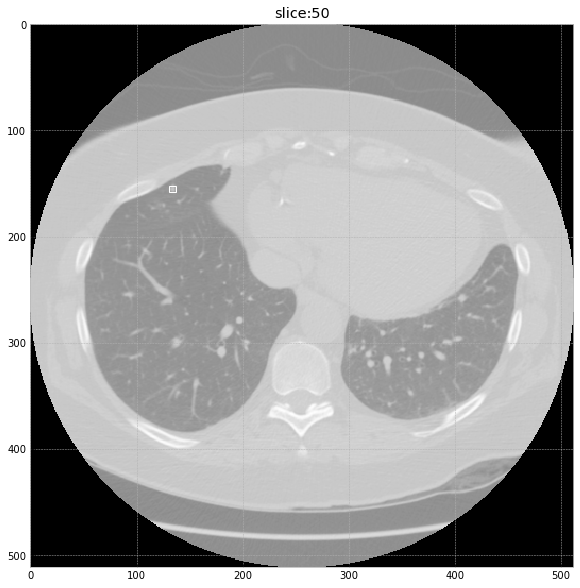

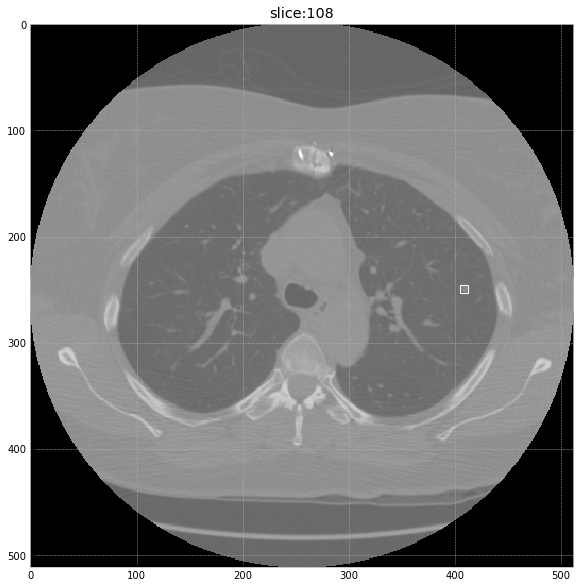

In [129]:
plot_slices_w_nodules(patient_id, anno_df, resample_img=False)

### Process Images Into PNG Slices

In [ ]:
def process_image(src_path):
    patient_id = ntpath.basename(src_path).replace(".mhd", "")
    print("Patient: ", patient_id)

    dst_dir = os.path.join(LUNA_EXTRACTED_IMAGE_PATH, patient_id)
    if not os.path.exists(dst_dir):
        os.mkdir(dst_dir)

    img_arr, origin, spacing = load_scan_arr(patient_id)
    img_arr, spacing = resample(img_arr, spacing, TARGET_VOXEL_MM)

    for i in range(img_arr.shape[0]):
        img = img_arr[i]
#         seg_img, mask = helpers.get_segmented_lungs(img.copy())
#         img_list.append(seg_img)
        img = normalize(img)
        cv2.imwrite(dst_dir + "/img_" + str(i).rjust(4, '0') + "_i.png", img * 255)
#         cv2.imwrite(dst_dir + "img_" + str(i).rjust(4, '0') + "_m.png", mask * 255)



def process_images(delete_existing=False, only_process_patient=None):
    if delete_existing and os.path.exists(LUNA_EXTRACTED_IMAGE_PATH):
        print("Removing old stuff..")
        if os.path.exists(LUNA_EXTRACTED_IMAGE_PATH):
            shutil.rmtree(LUNA_EXTRACTED_IMAGE_PATH)

    if not os.path.exists(LUNA_EXTRACTED_IMAGE_PATH):
        os.mkdir(LUNA_EXTRACTED_IMAGE_PATH)

    for subject_no in range(10):
        src_dir = os.path.join(
            LUNA_DATA_PATH, "subset" + str(subject_no)) + "/"
        src_paths = glob(src_dir + "*.mhd")

        if only_process_patient is None:
            pool = multiprocessing.Pool(8)
            pool.map(process_image, src_paths)
        else:
            for src_path in src_paths:
                if only_process_patient is not None:
                    if only_process_patient not in src_path:
                        continue
                process_image(src_path)

def load_patient_images(patient_id, base_dir=None, wildcard="*.*", exclude_wildcards=[]):
    src_dir = os.path.join(base_dir, patient_id)
    src_img_paths = glob(src_dir + '/' + wildcard)
    for exclude_wildcard in exclude_wildcards:
        exclude_img_paths = glob(src_dir + exclude_wildcard)
        src_img_paths = [im for im in src_img_paths if im not in exclude_img_paths]
    src_img_paths.sort()
    images = [cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) for img_path in src_img_paths]
    images = [im.reshape((1, ) + im.shape) for im in images]
    res = np.vstack(images)
    return res

In [ ]:
process_images(True, only_process_patient=None)

In [136]:
def get_scan_bbs2(img_arr, nodules):
    bbs = []
    for idx,nodule in nodules.iterrows():
        bbs.append(make_bb_from_nodule2(img_arr, nodule))
    return bbs
    
def make_bb_from_nodule2(img_arr, nodule):
    x,y,z,diameter = percent_to_pixels(
        nodule['x_center_perc'], nodule['y_center_perc'],
        nodule['z_center_perc'], nodule['diameter_perc'], 
        img_arr)
    return make_bb(z, y, x, diameter)
    
def plot_scan_w_nodules(img_arr, nodules):
    print("Patient: ", patient_id)
    bbs = get_scan_bbs2(img_arr, nodules)
    slice_idxs = get_slice_idx_to_bb_map(bbs)
    for idx in slice_idxs.keys():
        plot_slice_w_bbs(img_arr[idx], slice_idxs[idx], title="slice:"+str(idx))

/bigguy/data/luna/luna_extracted_imgs/1.3.6.1.4.1.14519.5.2.1.6279.6001.225227615446398900698431118292
Patient:  1.3.6.1.4.1.14519.5.2.1.6279.6001.225227615446398900698431118292


,idx,calcification,diameter_perc,img_x,img_y,img_z,internal_structure,lobulation,malscore,margin,...,spiculation,subtlety,texture,world_diameter,world_x,world_y,world_z,x_center_perc,y_center_perc,z_center_perc
496,496,6.0,0.050800,512,512,484,1.0,1.75,3.750000,5.000000,...,1.25,5.000000,5.00,13.204812,38.175585,76.658118,-217.880458,0.657700,0.784175,0.242250
497,497,6.0,0.021000,512,512,484,1.0,1.00,2.250000,4.500000,...,1.00,3.250000,4.75,4.438916,111.539721,26.173876,-216.273856,0.901625,0.617450,0.248450
498,498,6.0,0.022767,512,512,484,1.0,1.00,2.333333,4.666667,...,1.00,3.666667,5.00,4.586830,97.675987,59.954407,-182.464266,0.855133,0.730167,0.360867
499,499,6.0,0.027825,512,512,484,1.0,1.25,2.500000,4.500000,...,1.00,4.750000,5.00,5.315640,88.645329,37.124808,-129.282233,0.823500,0.652800,0.536175


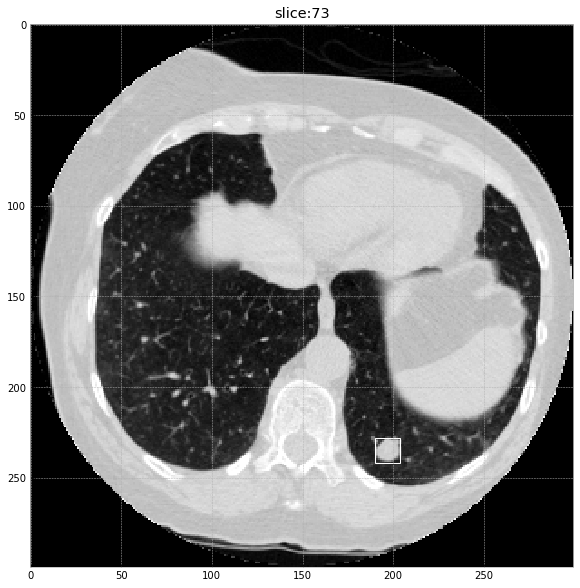

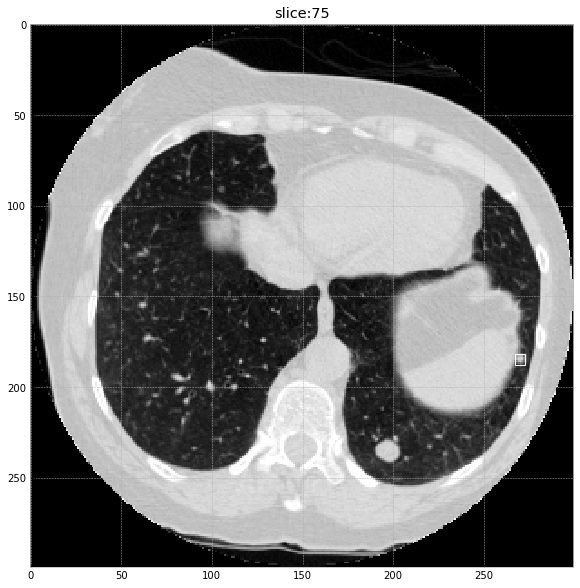

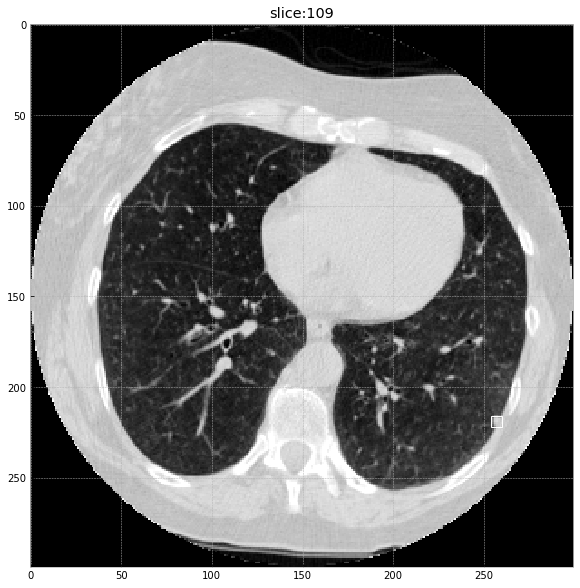

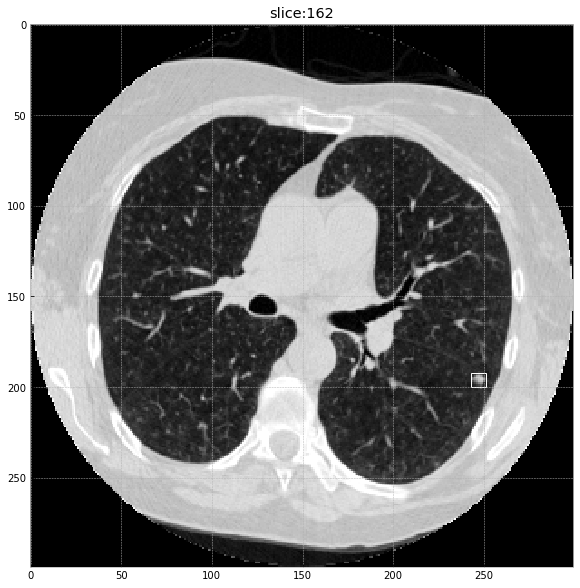

In [141]:
anno_df = luna_lidc_pos_df
patient_idx = random.randint(0,len(anno_df)-1)
patient_id = anno_df.iloc[patient_idx].patient_id
# img_arr, origin, spacing = load_scan_arr(patient_id)
# img_arr, spacing = resample(img_arr, spacing)

img_arr = load_patient_images(patient_id, LUNA_EXTRACTED_IMAGE_PATH, wildcard="*_i.png")
nodules = get_nodules_by_patient_id(patient_id, luna_lidc_pos_df)
plot_scan_w_nodules(img_arr, nodules)
nodules

### Resample Nodule Annotations

In [60]:
for idx,row in luna_lidc_pos_df.iterrows():
    patient_id = row['patient_id']
    img_arr,origin,old_spacing = load_scan_arr(patient_id)
    new_spacing = get_new_spacing(img_arr.shape, old_spacing, [1,1,1])
    print(new_spacing)
    break

[ 1.00057304  1.          1.        ]


In [77]:
old_img_shape = anno_df['orig_img_shape'][0].strip(')').strip('(').split(', ')
old_img_shape = [int(s) for s in old_img_shape]
old_img_shape

[194, 512, 512]

In [100]:

copy_luna_lidc = luna_lidc_pos_df.copy()
for idx,row in copy_luna_lidc.iterrows():
    patient_id = row['patient_id']
    old_origin = np.array([row['origin_z'], row['origin_y'], row['origin_x']]) 
    old_spacing = np.array([row['spacing_z'], row['spacing_y'], row['spacing_x']]) 
    old_shape = np.array([row['img_z'], row['img_y'], row['img_x']]) 
#    print("Old", old_spacing, old_shape)
    new_spacing, new_shape = get_new_spacing(old_img_shape, old_spacing, [1,1,1])
#    print("New", new_spacing, new_shape)
    img_z, img_y, img_x = new_shape
    spacing_z, spacing_y, spacing_x = new_spacing
    origin_z, origin_y, origin_x = old_origin
    pixel_z = get_pixel_from_world(row['world_z'], origin_z, spacing_z)
    pixel_y = get_pixel_from_world(row['world_y'], origin_y, spacing_y)
    pixel_x = get_pixel_from_world(row['world_x'], origin_x, spacing_x)
    pixel_diameter = get_pixel_diameter_from_world(row, spacing_x)
    row['pixel_z'] = pixel_z
    row['pixel_y'] = pixel_y
    row['pixel_x'] = pixel_x
    row['pixel_diameter'] = pixel_diameter

idx                                                                   0
calcification                                                         6
img_x                                                               512
img_y                                                               512
img_z                                                               194
internal_structure                                                    1
lobulation                                                            1
malscore                                                              3
margin                                                              4.5
origin_x                                                       -157.678
origin_y                                                       -311.678
origin_z                                                         -438.4
patient_id            1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...
pixel_diameter                                                  

/bigguy/data/luna/luna_extracted_imgs/1.3.6.1.4.1.14519.5.2.1.6279.6001.300146276266881736689307479986
Patient:  1.3.6.1.4.1.14519.5.2.1.6279.6001.300146276266881736689307479986


,idx,calcification,img_x,img_y,img_z,internal_structure,lobulation,malscore,margin,origin_x,...,spacing_y,spacing_z,sphericiy,spiculation,subtlety,texture,world_diameter,world_x,world_y,world_z
792,792,6.0,512,512,171,1.0,2.0,2.333333,3.000000,-124.726562,...,0.546875,1.8,3.333333,1.0,2.0,3.666667,4.805891,-68.440940,-157.113702,-176.185882
793,793,6.0,512,512,171,1.0,3.0,3.333333,3.333333,-124.726562,...,0.546875,1.8,3.666667,2.0,4.0,4.333333,6.821387,-55.107111,-92.466685,-105.125123


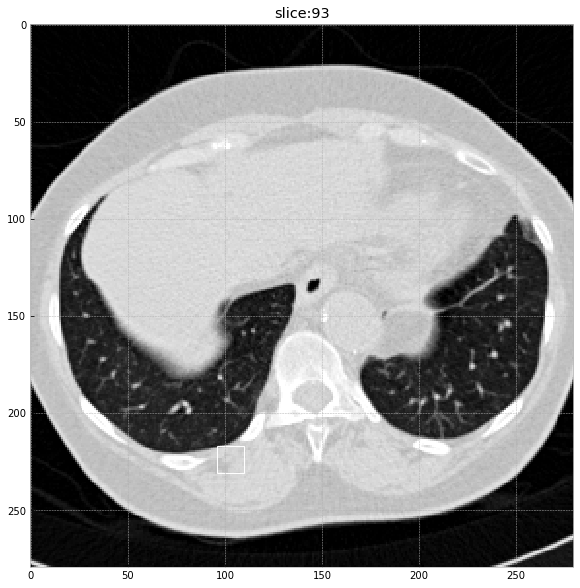

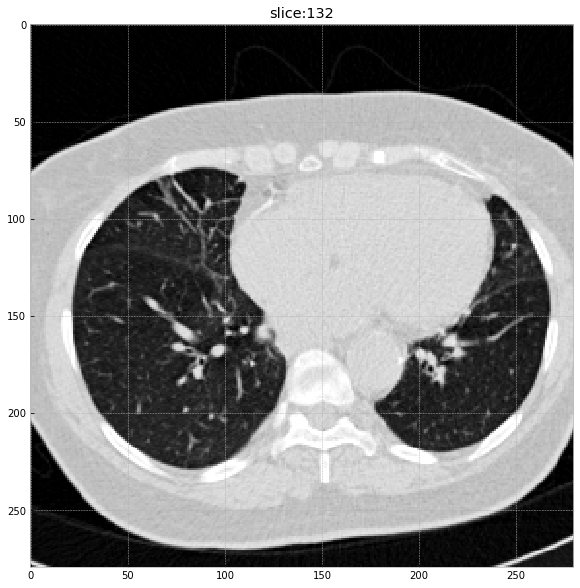

In [106]:
anno_df = luna_lidc_pos_df
patient_idx = random.randint(0,len(anno_df)-1)
patient_id = anno_df.iloc[patient_idx].patient_id
# img_arr, origin, spacing = load_scan_arr(patient_id)
# img_arr, spacing = resample(img_arr, spacing)

img_arr = load_patient_images(patient_id, LUNA_EXTRACTED_IMAGE_PATH, wildcard="*_i.png")
nodules = get_nodules_by_patient_id(patient_id, copy_luna_lidc)
plot_scan_w_nodules(img_arr, nodules)
nodules

### Create 3D Cubes

In [ ]:
# https://github.com/dhammack/DSB2017/blob/master/training_code/FLung_nodule_models/data_generator_fn.py
# https://github.com/juliandewit/kaggle_ndsb2017/blob/master/step1_preprocess_luna16.py
# https://www.kaggle.com/rodenluo/crop-save-and-view-nodules-in-3d/notebook
# https://github.com/juliandewit/kaggle_ndsb2017/blob/master/step1b_preprocess_make_train_cubes.py
CUBE_SIZE = 64

def resize_cube(x, desired_shape):
    factors = np.array(x.shape).astype('float32') / np.array(
        desired_shape).astype('float32')
    output= ndimage.interpolation.zoom(x,1.0 / factors,order=1)
    assert output.shape == desired_shape, 'resize error'
    return output

def make_3d_cube(img_arr, nodule, new_size=None):
    z,y,x = img_arr.shape
    bb = make_bb_from_nodule2(nodule)
    return img_arr[start_z:end_z, start_y:end_y, start_x:end_x]

def save_cube(fpath, cub_img):
    cv2.imwrite(fpath, cube_img)